In [1]:
import json

if __name__ == '__main__':
    data_path = 'data/clean_ner_with_bbox.json'
    
    with open(data_path, 'r', encoding='utf-8') as file:
        dataset = json.load(file)
    
dataset[0]

{'image': 'IMG_5306.jpg',
 'objects': [{'tokens': ['ifm', 'electronic'],
   'ner_tags': ['B-Company', 'I-Company'],
   'bbox': [786, 825, 1059, 825, 1059, 869, 786, 869]},
  {'tokens': ['Nguyễn', 'Xuân', 'Hoàng'],
   'ner_tags': ['B-Name', 'I-Name', 'I-Name'],
   'bbox': [107, 908, 514, 913, 513, 965, 106, 960]},
  {'tokens': ['Giám', 'Đốc'],
   'ner_tags': ['B-Position', 'I-Position'],
   'bbox': [107, 962, 277, 962, 277, 1006, 107, 1006]},
  {'tokens': ['Công', 'Ty', 'TNHH', 'ifm', 'electronic', 'Việt', 'Nam'],
   'ner_tags': ['B-Company',
    'I-Company',
    'I-Company',
    'I-Company',
    'I-Company',
    'I-Company',
    'I-Company'],
   'bbox': [677, 988, 1263, 983, 1264, 1019, 678, 1023]},
  {'tokens': ['Phòng', '401,', 'tầng', '4,', 'Tòa', 'nhà', 'HD', 'Tower'],
   'ner_tags': ['B-Address',
    'I-Address',
    'I-Address',
    'I-Address',
    'I-Address',
    'I-Address',
    'I-Address',
    'I-Address'],
   'bbox': [673, 1025, 1210, 1021, 1210, 1062, 674, 1067]},
  {'tok

In [2]:
def normalize_bbox_coords(bboxes):
    """Return normalized bboxes using min-max scaling."""
    all_x = [pt for bbox in bboxes for pt in bbox[::2]]
    all_y = [pt for bbox in bboxes for pt in bbox[1::2]]

    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)

    def norm(v, vmin, vmax):
        return (v - vmin) / (vmax - vmin) if vmax > vmin else 0.0

    normalized = []
    for bbox in bboxes:
        if len(bbox) != 8:
            normalized.append(bbox)  # skip malformed bboxes
            continue
        normalized.append([
            norm(bbox[0], min_x, max_x), norm(bbox[1], min_y, max_y),
            norm(bbox[2], min_x, max_x), norm(bbox[3], min_y, max_y),
            norm(bbox[4], min_x, max_x), norm(bbox[5], min_y, max_y),
            norm(bbox[6], min_x, max_x), norm(bbox[7], min_y, max_y),
        ])
    return normalized
    
for image in dataset:
    objects = image['objects']
    bboxes = [obj['bbox'] for obj in objects if len(obj['bbox']) == 8]
    
    normalized_bboxes = normalize_bbox_coords(bboxes)
    
    norm_idx = 0
    for obj in objects:
        if len(obj['bbox']) == 8:
            obj['bbox'] = normalized_bboxes[norm_idx]
            norm_idx += 1
        # else keep the original bbox as is


In [3]:
dataset[0]['objects'][0]['bbox']

[0.5907534246575342,
 0.0,
 0.824486301369863,
 0.0,
 0.824486301369863,
 0.0825515947467167,
 0.5907534246575342,
 0.0825515947467167]

In [4]:
LABEL_LIST = ["O", "B-Name", "I-Name", "B-Position", "I-Position", "B-Company", 
              "I-Company", "B-Address", "I-Address", "B-Phone", "I-Phone", "B-Email", 
              "I-Email", "B-Department", "I-Department", "B-Website", "I-Website"]

In [5]:
def plot_bboxes_all_in_one(dataset, ner_tags_query, ax=None, title=None):
    """
    Plot normalized bboxes in one color for all images combined, filtering by NER tags.
    Draws on a provided matplotlib Axes object if given.
    """
    if ax is None:
        ax = plt.gca()
        
    color = 'r'  # Use a single color for all boxes

    for image_data in dataset:
        objects = image_data['objects']
        for obj in objects:
            if any(tag in ner_tags_query for tag in obj['ner_tags']):
                bbox = obj['bbox']
                if isinstance(bbox, list) and len(bbox) == 8:
                    x = [bbox[0], bbox[2], bbox[4], bbox[6], bbox[0]]
                    y = [bbox[1], bbox[3], bbox[5], bbox[7], bbox[1]]
                    ax.plot(x, y, color + '-', linewidth=1.5, alpha=0.3)

    ax.invert_yaxis()
    ax.set_title(title or f"NER Tag(s): {', '.join(ner_tags_query)}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True)
    ax.set_aspect('equal')


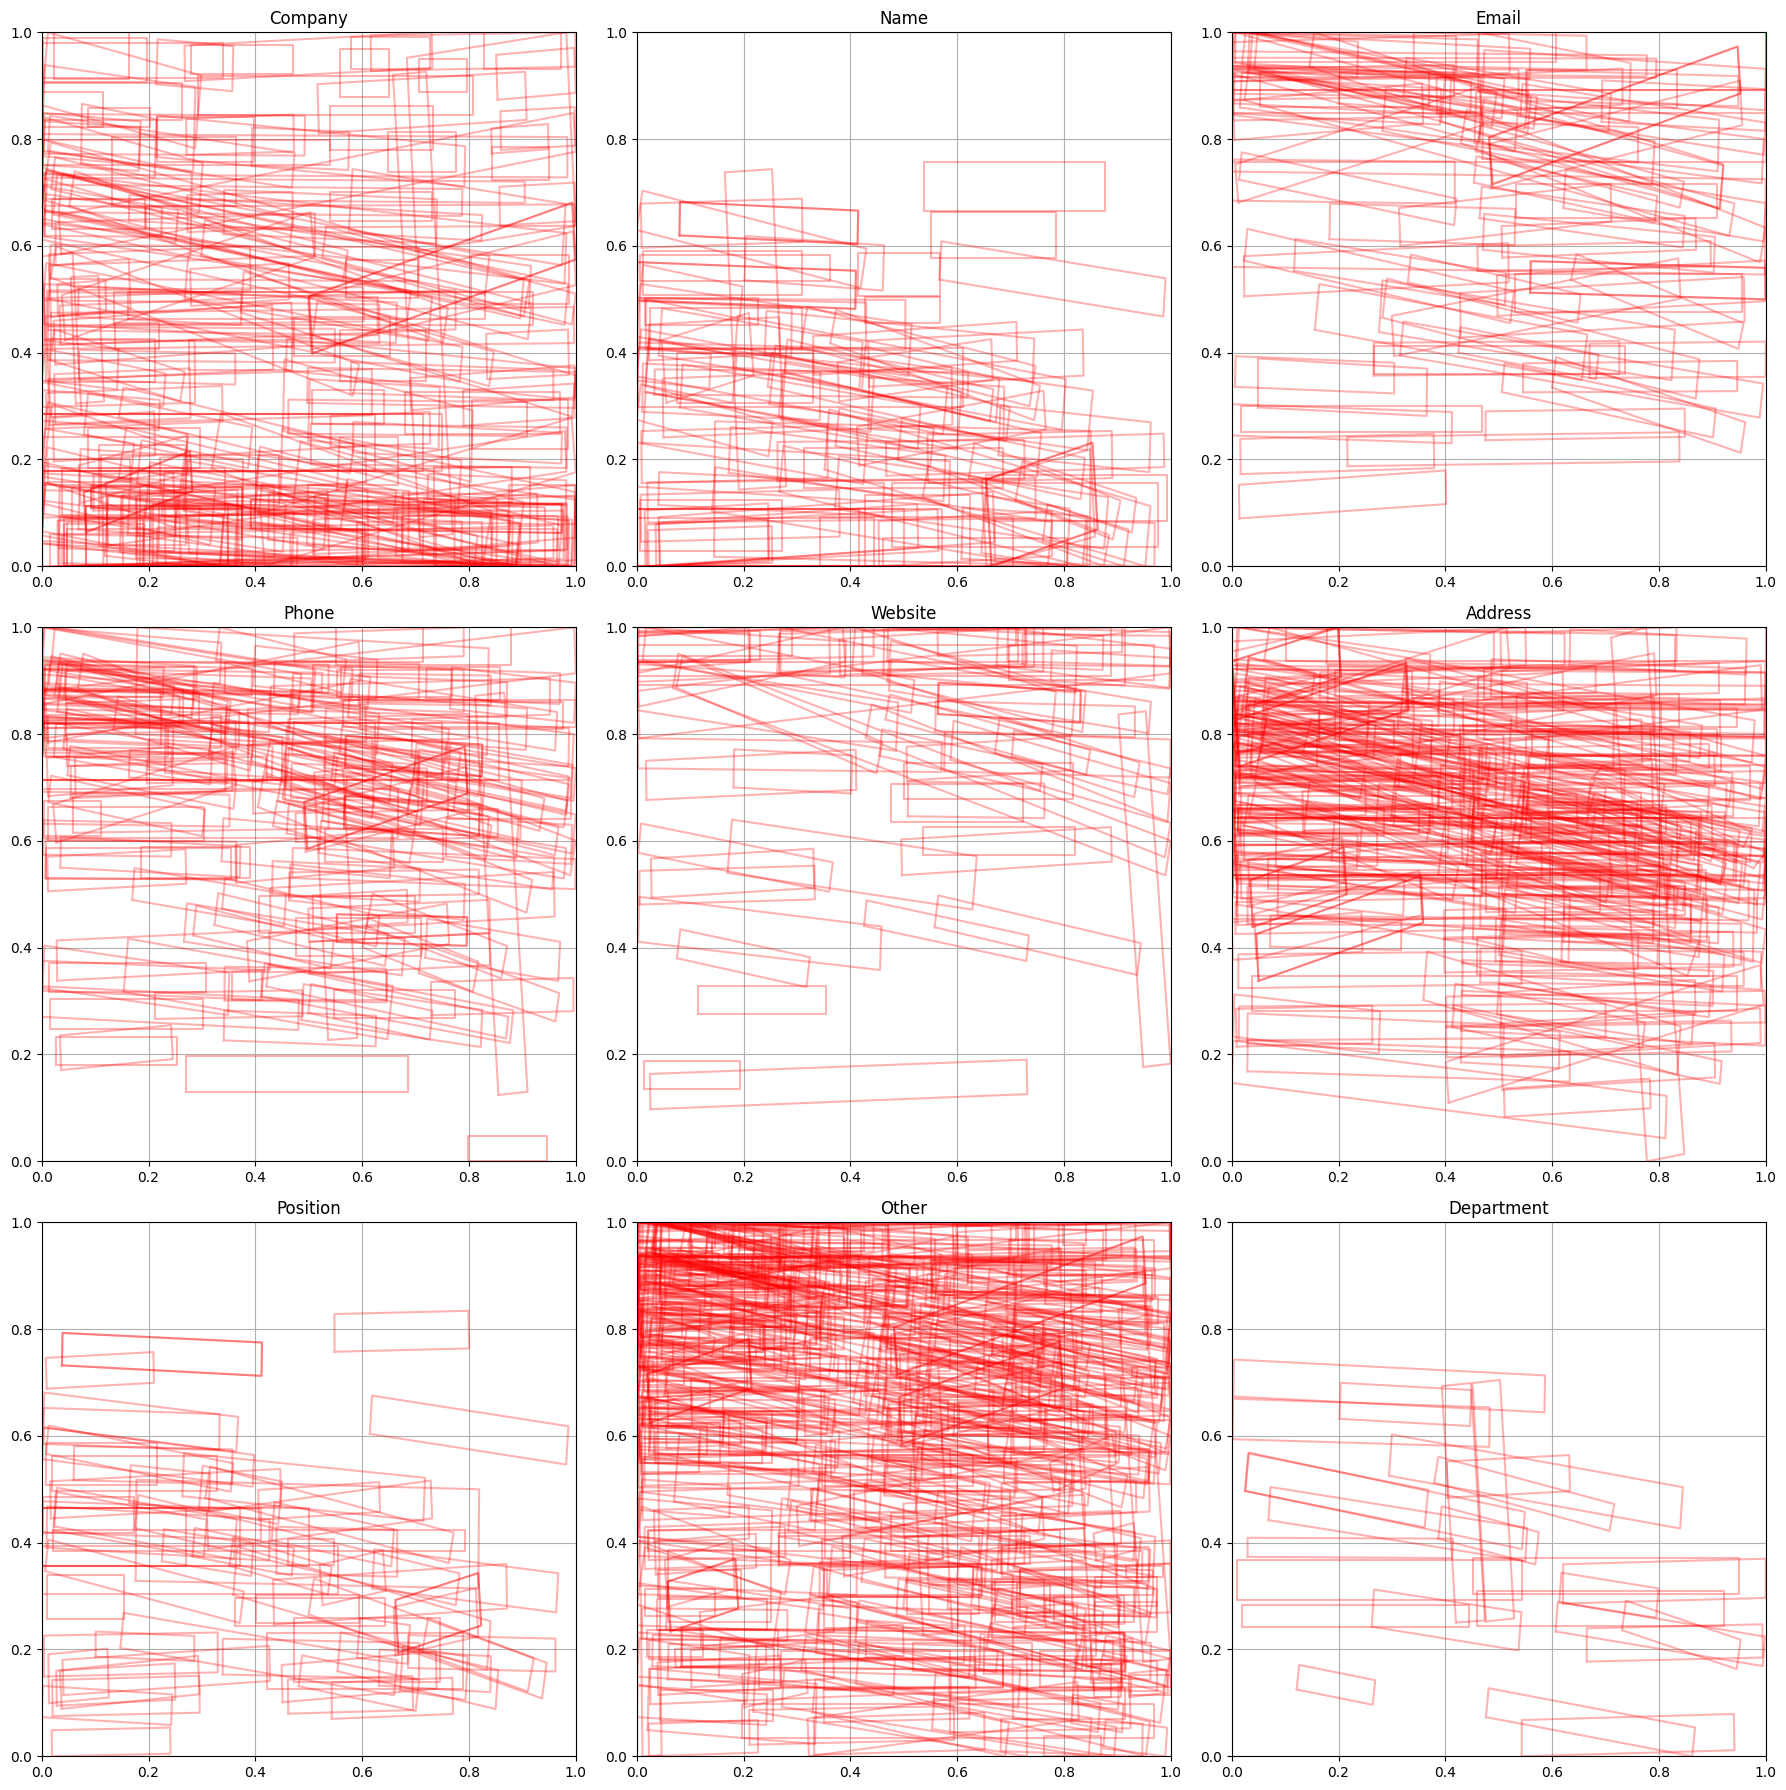

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # 3x3 grid

# Flatten the 2D array of axes for easier indexing
axes = axes.flatten()

# Now use each subplot
plt.sca(axes[0])
plot_bboxes_all_in_one(dataset, ['B-Company'], title="Company")

plt.sca(axes[1])
plot_bboxes_all_in_one(dataset, ['B-Name'], title="Name")

plt.sca(axes[2])
plot_bboxes_all_in_one(dataset, ['B-Email'], title="Email")

plt.sca(axes[3])
plot_bboxes_all_in_one(dataset, ['B-Phone'], title="Phone")

plt.sca(axes[4])
plot_bboxes_all_in_one(dataset, ['B-Website'], title="Website")

plt.sca(axes[5])
plot_bboxes_all_in_one(dataset, ['B-Address'], title="Address")

plt.sca(axes[6])
plot_bboxes_all_in_one(dataset, ['B-Position'], title="Position")

plt.sca(axes[7])
plot_bboxes_all_in_one(dataset, ['O'], title="Other")

plt.sca(axes[8])
plot_bboxes_all_in_one(dataset, ['B-Department'], title="Department")

plt.tight_layout()
plt.show()


In [16]:
def plot_bbox_centers_all_in_one(dataset, ner_tags_query, ax=None, title=None):
    """
    Plot center points of normalized bboxes for all images combined, filtered by NER tags.
    Draws on a provided matplotlib Axes object if given.
    """
    if ax is None:
        ax = plt.gca()

    color = 'r'  # Use a single color for all points

    for image_data in dataset:
        objects = image_data['objects']
        for obj in objects:
            if any(tag in ner_tags_query for tag in obj['ner_tags']):
                bbox = obj['bbox']
                if isinstance(bbox, list) and len(bbox) == 8:
                    xs = bbox[::2]
                    ys = bbox[1::2]
                    cx = sum(xs) / 4
                    cy = sum(ys) / 4
                    ax.plot(cx, cy, marker='o', color=color, alpha=0.5)

    ax.invert_yaxis()
    ax.set_title(title or f"Centers: {', '.join(ner_tags_query)}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True)
    ax.set_aspect('equal')


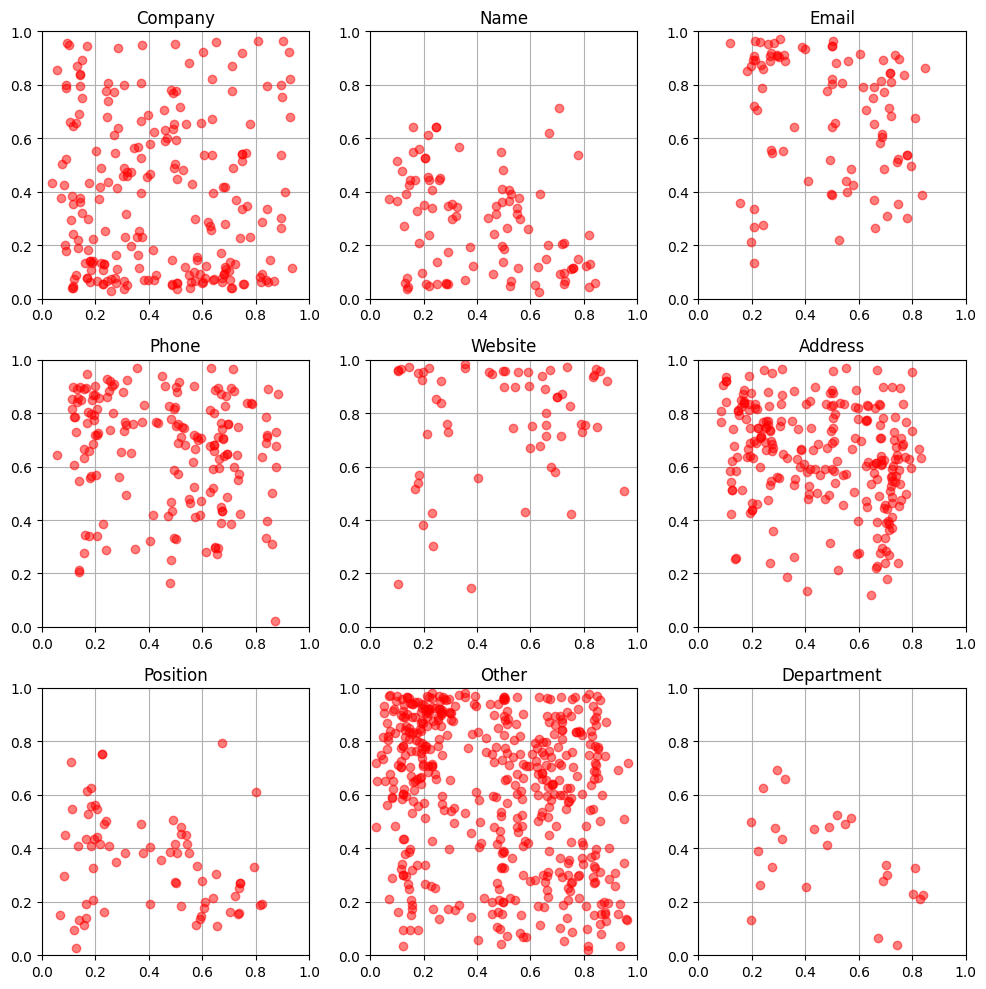

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

plot_bbox_centers_all_in_one(dataset, ['B-Company'], ax=axes[0], title="Company")
plot_bbox_centers_all_in_one(dataset, ['B-Name'], ax=axes[1], title="Name")
plot_bbox_centers_all_in_one(dataset, ['B-Email'], ax=axes[2], title="Email")
plot_bbox_centers_all_in_one(dataset, ['B-Phone'], ax=axes[3], title="Phone")
plot_bbox_centers_all_in_one(dataset, ['B-Website'], ax=axes[4], title="Website")
plot_bbox_centers_all_in_one(dataset, ['B-Address'], ax=axes[5], title="Address")
plot_bbox_centers_all_in_one(dataset, ['B-Position'], ax=axes[6], title="Position")
plot_bbox_centers_all_in_one(dataset, ['O'], ax=axes[7], title="Other")
plot_bbox_centers_all_in_one(dataset, ['B-Department'], ax=axes[8], title="Department")

plt.tight_layout()
plt.show()
